Loading data...
Data loaded successfully.
Total number of unique fault classes (including normal and -1 if present): 21
Original classes mapped to encoded integers: [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20)]
Features scaled. X_scaled shape: (732034, 54)
Data reshaped for GRU. X_reshaped shape: (732034, 1, 54)
Splitting data into training and testing sets...
X_train shape: (585627, 1, 54), y_train shape: (585627,)
X_test shape: (146407, 1, 54), y_test shape: (146407,)
Building Attention-GRU model...
Compiling model...
Training Attention-GRU model...
Epoch 1/50
14641/14641 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.7851 - loss: 0.7525 - val_accuracy: 0.8581 - val_loss: 0.4265
Epoch 2/50
14641/14641 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.8482 - loss: 0.4573 - val_accuracy: 0.8701 - val_loss: 0.3864
Epoch 3/50
14641/14641 ━━━━━━━━

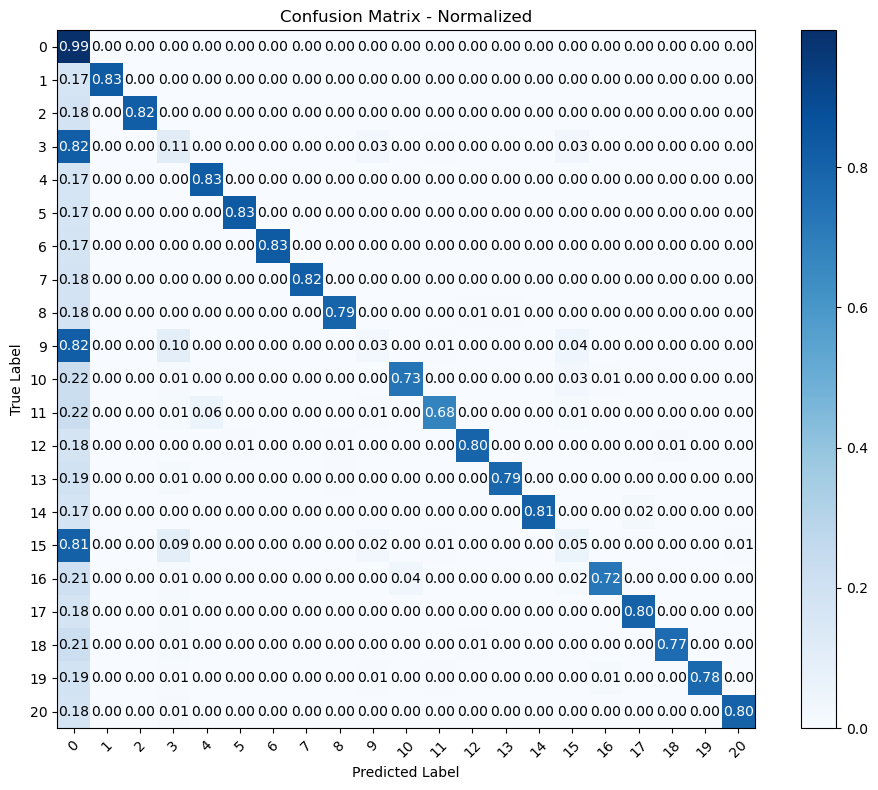

Confusion Matrix plot generated. 
Generating Training Curves...


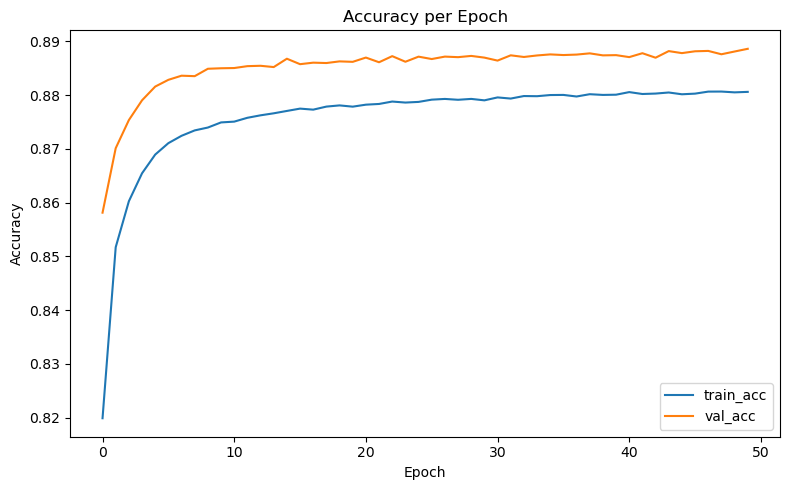

Accuracy per Epoch plot generated. 


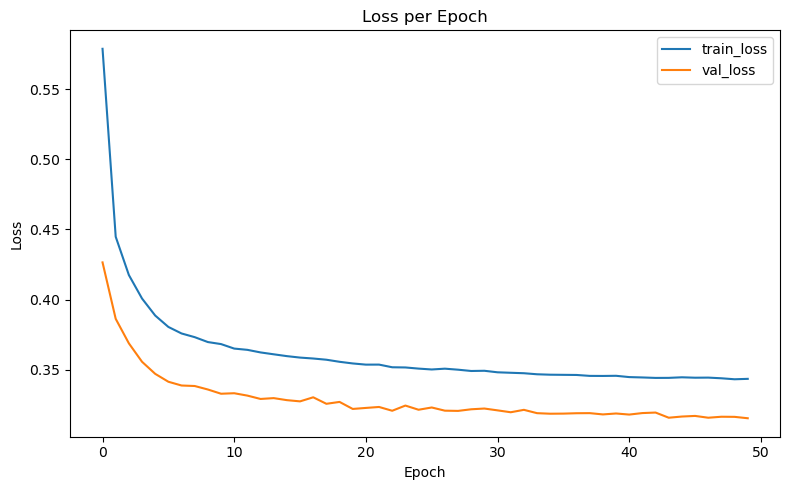

Loss per Epoch plot generated. 

Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1, 54)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 1, 64)          │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_1 (Attention)         │ (None, 64)             │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 21)             │           693 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,636 (303.27 KB)

 Trainable params: 25,878 (101.09 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 51,758 (202.18 KB)

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GRU, Dense, Dropout, Layer, Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Suppress TensorFlow warning messages
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# ---------------------------
# 1. Load and Prepare Data
# ---------------------------
# Load the datasets. Ensure 'FaultFree_Testing.csv' and 'Faulty_Testing.csv'
# are in the same directory as this script, or provide their full paths.
print("Loading data...")
try:
    df_faulty_free = pd.read_csv("FaultFree_Testing.csv")
    df_faulty_train = pd.read_csv("Faulty_Testing.csv")
    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading CSV files: {e}. Please ensure the files are in the correct directory.")
    exit() # Exit if files are not found

# Assign faultNumber 0 to fault-free data
df_faulty_free['faultNumber'] = 0

# Fill NaN values in 'faultNumber' for faulty training data with -1.
# This treats unassigned faulty cases as a distinct category.
df_faulty_train['faultNumber'] = df_faulty_train['faultNumber'].fillna(-1)

# Concatenate the fault-free and faulty datasets
df = pd.concat([df_faulty_free, df_faulty_train]).reset_index(drop=True)

# Separate features (X) and target labels (y)
X = df.drop(columns=['faultNumber']).values
y = df['faultNumber'].values

# Encode target labels to ensure they are sequential integers starting from 0.
# This is crucial for 'sparse_categorical_crossentropy' loss function.
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
print(f"Total number of unique fault classes (including normal and -1 if present): {num_classes}")
print(f"Original classes mapped to encoded integers: {list(zip(label_encoder.classes_, range(num_classes)))}")

# Standardize features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Features scaled. X_scaled shape: {X_scaled.shape}")

# Reshape data for GRU input: (samples, timesteps, features)
# For time-series data, `timesteps` could be > 1.
# For TEP, we often treat each observation as a single timestep for simplicity
# unless a specific windowing strategy is applied.
# Here, we keep timesteps=1, but the attention layer is designed to work with sequences.
# If you have actual sequences (e.g., multiple time-points per sample),
# `timesteps` should be adjusted and X should be reshaped accordingly.
timesteps = 1 # Assuming each row is a single time observation for simplicity.
num_features = X_scaled.shape[1]
X_reshaped = X_scaled.reshape(-1, timesteps, num_features)
print(f"Data reshaped for GRU. X_reshaped shape: {X_reshaped.shape}")

# ---------------------------
# 2. Train-Test Split
# ---------------------------
# Split the data into training and testing sets (80% train, 20% test).
# Stratify by y_encoded to ensure proportional representation of each class in splits.
print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# ---------------------------
# 3. Define Custom Attention Layer
# ---------------------------
class Attention(Layer):
    """
    Custom Attention Layer for Keras.

    This layer calculates attention weights over a sequence of inputs and
    produces a weighted sum, effectively allowing the model to focus on
    more important parts of the sequence.
    """
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        # input_shape is (batch_size, timesteps, features)
        # We need a weight matrix (kernel) to project the features to a single score per timestep.
        # This will be used for the dot product.
        self.kernel = self.add_weight(name='attention_kernel',
                                     shape=(input_shape[-1], 1), # Project features to a single score
                                     initializer='glorot_uniform', # Common initializer for weights
                                     trainable=True)
        # A bias for the scores, applied after the dot product
        self.bias = self.add_weight(name='attention_bias',
                                   shape=(1,), # A single bias value
                                   initializer='zeros',
                                   trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        # Inputs shape: (batch_size, timesteps, features)

        # Step 1: Compute attention energies (scores)
        # Apply a dense-like transformation: (inputs @ kernel) + bias
        # K.dot( (batch_size, timesteps, features), (features, 1) ) -> (batch_size, timesteps, 1)
        energy = K.tanh(K.dot(inputs, self.kernel) + self.bias)

        # Squeeze the last dimension to get (batch_size, timesteps)
        # This tensor now holds the attention score for each timestep.
        energy = K.squeeze(energy, axis=-1)

        # Step 2: Apply softmax over the timesteps axis to get attention weights
        # Softmax ensures weights sum to 1 across timesteps for each sample.
        # (batch_size, timesteps)
        attention_weights = K.softmax(energy, axis=-1)

        # Step 3: Apply attention weights to inputs (weighted sum)
        # K.expand_dims(attention_weights, -1) reshapes to (batch_size, timesteps, 1)
        # This allows for broadcasting during element-wise multiplication with inputs.
        # (batch_size, timesteps, 1) * (batch_size, timesteps, features)
        weighted_output = inputs * K.expand_dims(attention_weights, -1)

        # Step 4: Sum over timesteps to get the context vector
        # This reduces the (batch_size, timesteps, features) to (batch_size, features),
        # representing the weighted sum of features for each sample.
        output = K.sum(weighted_output, axis=1)

        return output # This is the context vector, which is the output of the attention layer

    def compute_output_shape(self, input_shape):
        # The output shape will be (batch_size, features) after summing over timesteps
        return (input_shape[0], input_shape[-1])

# ---------------------------
# 4. Build Attention-GRU Model
# ---------------------------
print("Building Attention-GRU model...")
# Define the input layer
input_layer = Input(shape=(timesteps, num_features))

# GRU layer: 'return_sequences=True' is crucial because the Attention layer
# needs the output of the GRU at each timestep, not just the last one.
gru_output = GRU(units=64, return_sequences=True)(input_layer)
gru_output = Dropout(0.2)(gru_output) # Dropout after GRU for regularization

# Apply the custom Attention layer
attention_output = Attention()(gru_output)

# Dense layers after attention for classification
dense_layer_1 = Dense(units=32, activation='relu')(attention_output)
dense_layer_1 = Dropout(0.2)(dense_layer_1) # Another dropout layer

# Output layer with softmax activation for multi-class classification
output_layer = Dense(units=num_classes, activation='softmax')(dense_layer_1)

# Create the model using the Keras Functional API
model = Model(inputs=input_layer, outputs=output_layer)


# ---------------------------
# 5. Compile and Train Model
# ---------------------------
print("Compiling model...")
model.compile(optimizer='adam', # Adam optimizer is a good default choice
              loss='sparse_categorical_crossentropy', # Suitable for integer-encoded labels
              metrics=['accuracy']) # Monitor accuracy during training

# Define EarlyStopping callback to stop training when validation loss stops improving.
# 'patience=10' means it will wait for 10 epochs before stopping if no improvement.
# 'restore_best_weights=True' ensures the model uses the weights from the epoch with the best validation loss.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("Training Attention-GRU model...")
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,          # Maximum number of training epochs
    batch_size=32,      # Number of samples per gradient update
    validation_split=0.2, # Use 20% of the training data as validation set
    callbacks=[early_stopping], # Apply early stopping
    verbose=1           # Display training progress
)
print("Model training complete.")

# ---------------------------
# 6. Evaluate Model
# ---------------------------
print("\nEvaluating model on test data...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Predict probabilities for the test set
y_pred_probs = model.predict(X_test)
# Convert probabilities to class labels (index of the highest probability)
y_pred = np.argmax(y_pred_probs, axis=1)

# Overall Accuracy
overall_acc = accuracy_score(y_test, y_pred)
print(f"\nOverall Accuracy: {overall_acc:.4f}")

# Per-class metrics using Classification Report
print("\nClassification Report (per fault class):")
# 'target_names' are the original class labels before encoding, for better readability.
print(classification_report(y_test, y_pred, digits=4, target_names=label_encoder.classes_.astype(str)))

# ---------------------------
# 7. Confusion Matrix
# ---------------------------
print("\nGenerating Confusion Matrix...")
# Get unique encoded classes for the confusion matrix labels
classes = np.unique(y_encoded)
cm = confusion_matrix(y_test, y_pred, labels=classes)
tick_marks = np.arange(len(classes))

# Normalize the confusion matrix for better interpretability (percentages)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
plt.imshow(cm_norm, interpolation='nearest', cmap="Blues")
plt.title("Confusion Matrix - Normalized")
plt.colorbar()
# Set x and y axis ticks to original class names
plt.xticks(tick_marks, label_encoder.classes_.astype(str), rotation=45)
plt.yticks(tick_marks, label_encoder.classes_.astype(str))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add text annotations to each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}",
                 ha="center", va="center",
                 color="white" if cm_norm[i, j] > 0.5 else "black") # White text for dark cells, black for light cells
plt.tight_layout()
plt.show()
print("Confusion Matrix plot generated. ")

# ---------------------------
# 8. Training Curves
# ---------------------------
print("Generating Training Curves...")
# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()
print("Accuracy per Epoch plot generated. ")

# Plot training and validation loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()
print("Loss per Epoch plot generated. ")

# ---------------------------
# Model Summary
# ---------------------------
print("\nModel Summary:")
model.summary()


Loading data...
Data loaded successfully.
Total number of unique fault classes (including normal and -1 if present): 21
Original classes mapped to encoded integers: [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20)]
Features scaled. X_scaled shape: (732034, 54)
Data reshaped for GRU. X_reshaped shape: (732034, 1, 54)
Splitting data into training and testing sets...
X_train shape: (585627, 1, 54), y_train shape: (585627,)
X_test shape: (146407, 1, 54), y_test shape: (146407,)
Building Attention-GRU model...
Compiling model...
Training Attention-GRU model...
Epoch 1/100
14641/14641 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - accuracy: 0.7951 - loss: 0.6992 - val_accuracy: 0.8648 - val_loss: 0.4055
Epoch 2/100
14641/14641 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - accuracy: 0.8555 - loss: 0.4371 - val_accuracy: 0.8741 - val_loss: 0.3774
Epoch 3/100
14641/14641 ━━━━━

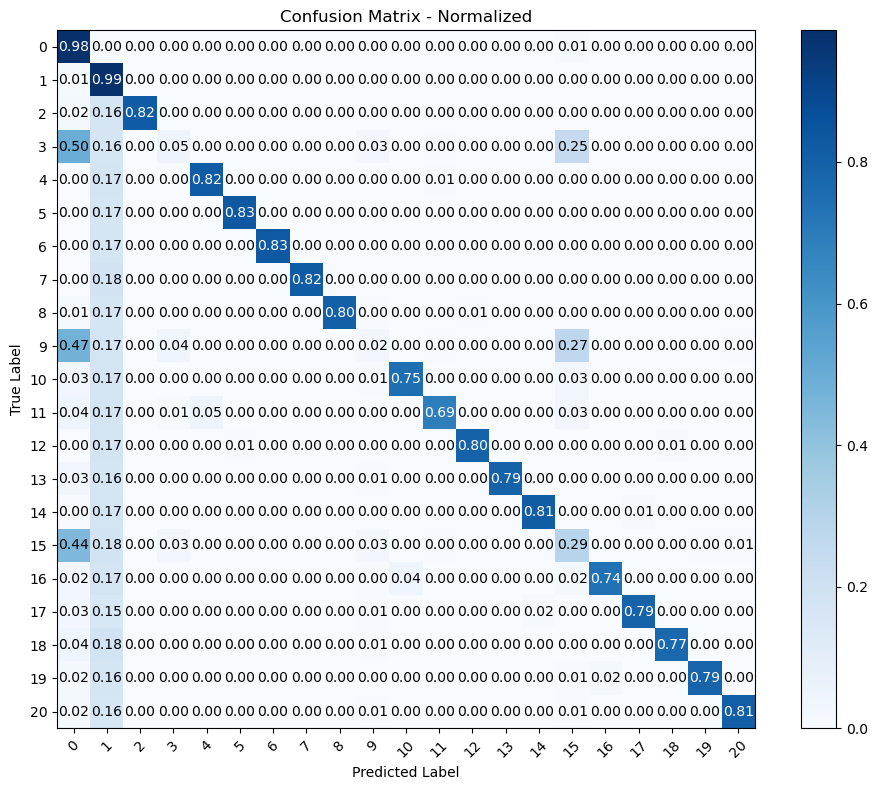

Confusion Matrix plot generated. 
Generating Training Curves...


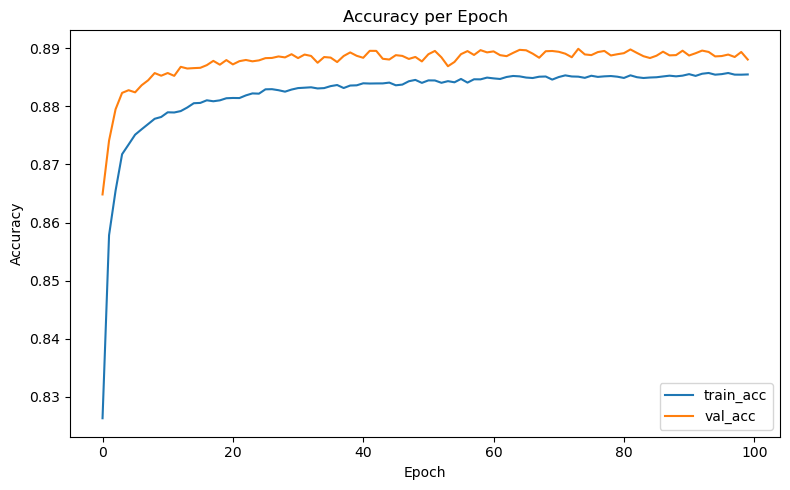

Accuracy per Epoch plot generated. 


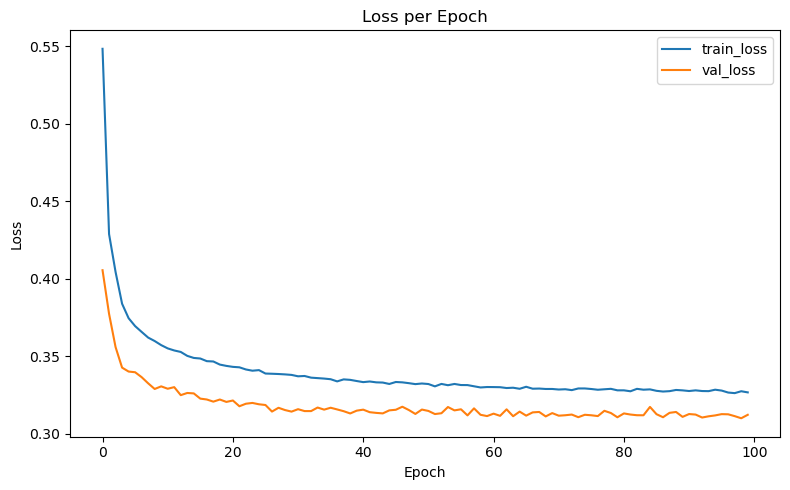

Loss per Epoch plot generated. 

Model Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1, 54)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 1, 128)         │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_2 (Attention)         │ (None, 128)            │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 21)             │           693 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 245,444 (958.77 KB)

 Trainable params: 81,814 (319.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 163,630 (639.18 KB)

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GRU, Dense, Dropout, Layer, Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Suppress TensorFlow warning messages
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# ---------------------------
# 1. Load and Prepare Data
# ---------------------------
# Load the datasets. Ensure 'FaultFree_Testing.csv' and 'Faulty_Testing.csv'
# are in the same directory as this script, or provide their full paths.
print("Loading data...")
try:
    df_faulty_free = pd.read_csv("FaultFree_Testing.csv")
    df_faulty_train = pd.read_csv("Faulty_Testing.csv")
    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading CSV files: {e}. Please ensure the files are in the correct directory.")
    exit() # Exit if files are not found

# Assign faultNumber 0 to fault-free data
df_faulty_free['faultNumber'] = 0

# Fill NaN values in 'faultNumber' for faulty training data with -1.
# This treats unassigned faulty cases as a distinct category.
df_faulty_train['faultNumber'] = df_faulty_train['faultNumber'].fillna(-1)

# Concatenate the fault-free and faulty datasets
df = pd.concat([df_faulty_free, df_faulty_train]).reset_index(drop=True)

# Separate features (X) and target labels (y)
X = df.drop(columns=['faultNumber']).values
y = df['faultNumber'].values

# Encode target labels to ensure they are sequential integers starting from 0.
# This is crucial for 'sparse_categorical_crossentropy' loss function.
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
print(f"Total number of unique fault classes (including normal and -1 if present): {num_classes}")
print(f"Original classes mapped to encoded integers: {list(zip(label_encoder.classes_, range(num_classes)))}")

# Standardize features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Features scaled. X_scaled shape: {X_scaled.shape}")

# Reshape data for GRU input: (samples, timesteps, features)
# For time-series data, `timesteps` could be > 1.
# For TEP, we often treat each observation as a single timestep for simplicity
# unless a specific windowing strategy is applied.
# Here, we keep timesteps=1, but the attention layer is designed to work with sequences.
# If you have actual sequences (e.g., multiple time-points per sample),
# `timesteps` should be adjusted and X should be reshaped accordingly.
timesteps = 1 # Assuming each row is a single time observation for simplicity.
num_features = X_scaled.shape[1]
X_reshaped = X_scaled.reshape(-1, timesteps, num_features)
print(f"Data reshaped for GRU. X_reshaped shape: {X_reshaped.shape}")

# ---------------------------
# 2. Train-Test Split
# ---------------------------
# Split the data into training and testing sets (80% train, 20% test).
# Stratify by y_encoded to ensure proportional representation of each class in splits.
print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# ---------------------------
# 3. Define Custom Attention Layer
# ---------------------------
class Attention(Layer):
    """
    Custom Attention Layer for Keras.

    This layer calculates attention weights over a sequence of inputs and
    produces a weighted sum, effectively allowing the model to focus on
    more important parts of the sequence.
    """
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        # input_shape is (batch_size, timesteps, features)
        # We need a weight matrix (kernel) to project the features to a single score per timestep.
        # This will be used for the dot product.
        self.kernel = self.add_weight(name='attention_kernel',
                                     shape=(input_shape[-1], 1), # Project features to a single score
                                     initializer='glorot_uniform', # Common initializer for weights
                                     trainable=True)
        # A bias for the scores, applied after the dot product
        self.bias = self.add_weight(name='attention_bias',
                                   shape=(1,), # A single bias value
                                   initializer='zeros',
                                   trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        # Inputs shape: (batch_size, timesteps, features)

        # Step 1: Compute attention energies (scores)
        # Apply a dense-like transformation: (inputs @ kernel) + bias
        # K.dot( (batch_size, timesteps, features), (features, 1) ) -> (batch_size, timesteps, 1)
        energy = K.tanh(K.dot(inputs, self.kernel) + self.bias)

        # Squeeze the last dimension to get (batch_size, timesteps)
        # This tensor now holds the attention score for each timestep.
        energy = K.squeeze(energy, axis=-1)

        # Step 2: Apply softmax over the timesteps axis to get attention weights
        # Softmax ensures weights sum to 1 across timesteps for each sample.
        # (batch_size, timesteps)
        attention_weights = K.softmax(energy, axis=-1)

        # Step 3: Apply attention weights to inputs (weighted sum)
        # K.expand_dims(attention_weights, -1) reshapes to (batch_size, timesteps, 1)
        # This allows for broadcasting during element-wise multiplication with inputs.
        # (batch_size, timesteps, 1) * (batch_size, timesteps, features)
        weighted_output = inputs * K.expand_dims(attention_weights, -1)

        # Step 4: Sum over timesteps to get the context vector
        # This reduces the (batch_size, timesteps, features) to (batch_size, features),
        # representing the weighted sum of features for each sample.
        output = K.sum(weighted_output, axis=1)

        return output # This is the context vector, which is the output of the attention layer

    def compute_output_shape(self, input_shape):
        # The output shape will be (batch_size, features) after summing over timesteps
        return (input_shape[0], input_shape[-1])

# ---------------------------
# 4. Build Attention-GRU Model
# ---------------------------
print("Building Attention-GRU model...")
# Define the input layer
input_layer = Input(shape=(timesteps, num_features))

# GRU layer: 'return_sequences=True' is crucial because the Attention layer
# needs the output of the GRU at each timestep, not just the last one.
# Increased units from 64 to 128
gru_output = GRU(units=128, return_sequences=True)(input_layer)
gru_output = Dropout(0.2)(gru_output) # Dropout after GRU for regularization

# Apply the custom Attention layer
attention_output = Attention()(gru_output)

# Dense layers after attention for classification
# Increased units from 32 to 64
dense_layer_1 = Dense(units=64, activation='relu')(attention_output)
dense_layer_1 = Dropout(0.2)(dense_layer_1) # Another dropout layer

# Added another Dense layer for more complexity
dense_layer_2 = Dense(units=32, activation='relu')(dense_layer_1)
dense_layer_2 = Dropout(0.2)(dense_layer_2)


# Output layer with softmax activation for multi-class classification
output_layer = Dense(units=num_classes, activation='softmax')(dense_layer_2) # Connected to new dense_layer_2

# Create the model using the Keras Functional API
model = Model(inputs=input_layer, outputs=output_layer)


# ---------------------------
# 5. Compile and Train Model
# ---------------------------
print("Compiling model...")
model.compile(optimizer='adam', # Adam optimizer is a good default choice
              loss='sparse_categorical_crossentropy', # Suitable for integer-encoded labels
              metrics=['accuracy']) # Monitor accuracy during training

# Define EarlyStopping callback to stop training when validation loss stops improving.
# 'patience=10' means it will wait for 10 epochs before stopping if no improvement.
# 'restore_best_weights=True' ensures the model uses the weights from the epoch with the best validation loss.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) # Increased patience

print("Training Attention-GRU model...")
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,          # Maximum number of training epochs (increased)
    batch_size=32,      # Number of samples per gradient update
    validation_split=0.2, # Use 20% of the training data as validation set
    callbacks=[early_stopping], # Apply early stopping
    verbose=1           # Display training progress
)
print("Model training complete.")

# ---------------------------
# 6. Evaluate Model
# ---------------------------
print("\nEvaluating model on test data...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Predict probabilities for the test set
y_pred_probs = model.predict(X_test)
# Convert probabilities to class labels (index of the highest probability)
y_pred = np.argmax(y_pred_probs, axis=1)

# Overall Accuracy
overall_acc = accuracy_score(y_test, y_pred)
print(f"\nOverall Accuracy: {overall_acc:.4f}")

# Per-class metrics using Classification Report
print("\nClassification Report (per fault class):")
# 'target_names' are the original class labels before encoding, for better readability.
print(classification_report(y_test, y_pred, digits=4, target_names=label_encoder.classes_.astype(str)))

# ---------------------------
# 7. Confusion Matrix
# ---------------------------
print("\nGenerating Confusion Matrix...")
# Get unique encoded classes for the confusion matrix labels
classes = np.unique(y_encoded)
cm = confusion_matrix(y_test, y_pred, labels=classes)
tick_marks = np.arange(len(classes))

# Normalize the confusion matrix for better interpretability (percentages)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
plt.imshow(cm_norm, interpolation='nearest', cmap="Blues")
plt.title("Confusion Matrix - Normalized")
plt.colorbar()
# Set x and y axis ticks to original class names
plt.xticks(tick_marks, label_encoder.classes_.astype(str), rotation=45)
plt.yticks(tick_marks, label_encoder.classes_.astype(str))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add text annotations to each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}",
                 ha="center", va="center",
                 color="white" if cm_norm[i, j] > 0.5 else "black") # White text for dark cells, black for light cells
plt.tight_layout()
plt.show()
print("Confusion Matrix plot generated. ")

# ---------------------------
# 8. Training Curves
# ---------------------------
print("Generating Training Curves...")
# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()
print("Accuracy per Epoch plot generated. ")

# Plot training and validation loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()
print("Loss per Epoch plot generated. ")

# ---------------------------
# Model Summary
# ---------------------------
print("\nModel Summary:")
model.summary()
